In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.pipeline import Pipeline

In [7]:
train_data = pd.read_csv('balanced5k.csv')
valid_data = pd.read_csv('fer_dev_nodup.csv')
train_data.head()

,Unnamed: 0,emotion,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,...,p_2294,p_2295,p_2296,p_2297,p_2298,p_2299,p_2300,p_2301,p_2302,p_2303
0,0,0,70,80,82,72,58,58,60,63,...,159,182,183,136,106,116,95,106,109,82
1,1,0,151,150,147,155,148,133,111,140,...,105,108,95,108,102,67,171,193,183,184
2,10,0,30,24,21,23,25,25,49,67,...,92,106,111,148,137,176,174,172,173,173
3,22,0,123,125,124,142,209,226,234,236,...,105,103,116,111,105,105,103,97,91,89
4,23,0,8,9,14,21,26,32,37,46,...,77,74,75,74,80,91,101,103,122,130


In [11]:
X_train = train_data.loc[:, 'p_0':'p_2303']
y_train = train_data['emotion']


X_valid = valid_data.loc[:, 'p_0':'p_2303']
y_valid = valid_data['emotion']

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(31524, 2304)
(31524,)
(3293, 2304)
(3293,)


### **ML - EDA**

#### 2-D Visualizations with isomap and T-sne

For visualization - we choose a sample of 200 images for each class

In [14]:
n = 200
groups = np.unique(y_train)
sample_df = pd.DataFrame()

for group in groups:
    temp_df = train_data.loc[train_data.emotion == group, :]
    temp_df = temp_df.sample(n)
    sample_df = pd.concat([sample_df, temp_df])

In [15]:
X_train_red = sample_df.loc[:, 'p_0':'p_2303']
y_train_red = sample_df['emotion']

**Visualization with PCA and tSNE**

In [16]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=0)),
    ("tsne", TSNE(n_components=2, random_state=0))])

components = pca_tsne.fit_transform(X_train_red)

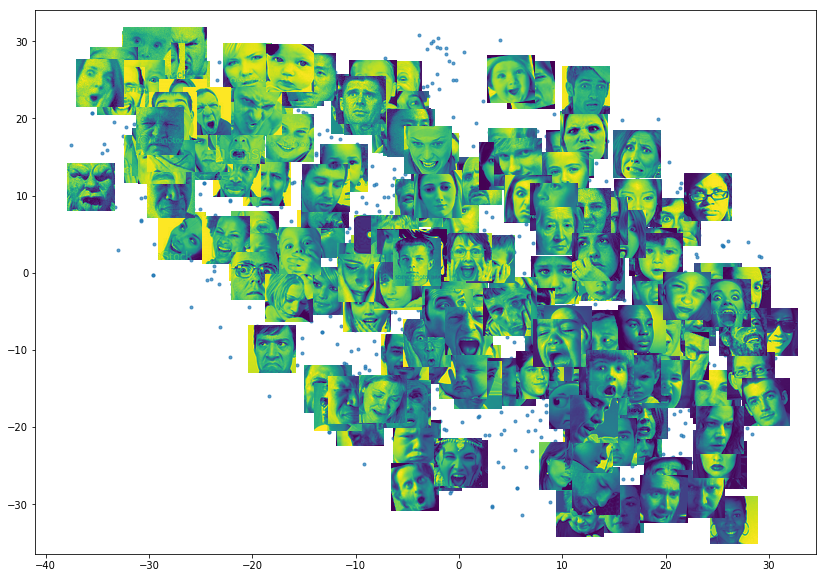

In [17]:
fig = plt.figure()
fig.set_size_inches(14, 10)
ax = fig.add_subplot(111)

# Show 2D components plot
ax.scatter(components[:,0].real, components[:,1].real, marker='.',alpha=0.7)


for _ in range(200):
        random_index = np.random.randint(X_train_red.shape[0])
        array_to_img = X_train_red.iloc[random_index].values.reshape(48, 48)
        ab = AnnotationBbox(OffsetImage(array_to_img), (components[:, 0][random_index].real, components[:, 1][random_index].real),frameon=False)
        ax.add_artist(ab)

**Visualization with ISOMAP**

In [18]:
iso = Isomap(n_neighbors=5, n_components=2)

iso.fit(X_train_red)

manifold_2Da = iso.transform(X_train_red)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])
manifold_2D.head()

,Component 1,Component 2
0,1580.002827,426.347267
1,-560.812630,-1305.187267
2,2426.244911,2536.267447
3,-7748.393355,2094.760574
4,-6300.527546,2276.481103


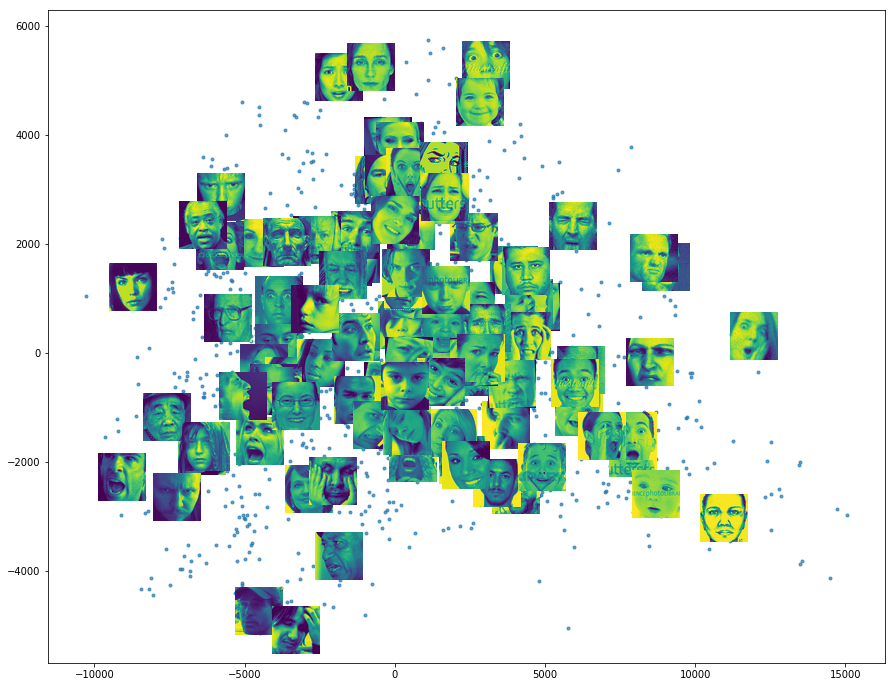

In [20]:
#plot of the two componenets

fig = plt.figure()
fig.set_size_inches(15, 12)
ax = fig.add_subplot(111)
# Show 2D components plot
ax.scatter(manifold_2D['Component 1'], manifold_2D['Component 2'], marker='.',alpha=0.7)

for _ in range(100):
    random_index = np.random.randint(X_train_red.shape[0])
    array_to_img = X_train_red.iloc[random_index].values.reshape(48, 48)
    ab = AnnotationBbox(OffsetImage(array_to_img), (manifold_2D['Component 1'][random_index], 
                                                    manifold_2D['Component 2'][random_index]),
                                                    frameon=False)
    ax.add_artist(ab)

Comment: We can see that the dimensionality reduction, in both cases, wasn't good. We suspect the that the brightness of the the image and the background(black, white) interferred in the reduction.

### Modeling

In [21]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

**Split to train and test**

**Random Forest -**

In [22]:
rf_model = RandomForestClassifier()

#fit model
rf_model.fit(X_train, y_train)

#predictions
rf_preds = rf_model.predict(X_valid)

In [23]:
print('Accuracy score: ', accuracy_score(y_valid, rf_preds), '\n')
print('Confusion matrix: \n', confusion_matrix(y_valid, rf_preds), '\n')
print('Report: \n', classification_report(y_valid, rf_preds))

Accuracy score:  0.4014576374126936 

Confusion matrix: 
 [[107   0  49  76  92  35  76]
 [  5   2   6  11   7   4   6]
 [ 49   0 117  54  82  64  79]
 [ 77   0  59 471  94  54 110]
 [ 92   0  65 102 228  31 107]
 [ 16   0  26  24  27 171  32]
 [ 60   0  66  73 116  45 226]] 

Report: 
               precision    recall  f1-score   support

           0       0.26      0.25      0.25       435
           1       1.00      0.05      0.09        41
           2       0.30      0.26      0.28       445
           3       0.58      0.54      0.56       865
           4       0.35      0.36      0.36       625
           5       0.42      0.58      0.49       296
           6       0.36      0.39      0.37       586

    accuracy                           0.40      3293
   macro avg       0.47      0.35      0.34      3293
weighted avg       0.41      0.40      0.40      3293



**Adaboost**

In [24]:
ada_model = AdaBoostClassifier()

#fit model
ada_model.fit(X_train, y_train)

#predictions
ada_preds = ada_model.predict(X_valid)

In [25]:
print('Accuracy score: ', accuracy_score(y_valid, ada_preds), '\n')
print('Confusion matrix: \n', confusion_matrix(y_valid, ada_preds), '\n')
print('Report: \n', classification_report(y_valid, ada_preds))

Accuracy score:  0.3048891588217431 

Confusion matrix: 
 [[ 48   1  30 131  64  55 106]
 [  9   0   2  15   4   3   8]
 [ 35   1  38 114  65  93  99]
 [ 55   1  47 421  84  61 196]
 [ 59   4  37 162 147  41 175]
 [ 17   1  23  45  38 119  53]
 [ 32   4  35 134  80  70 231]] 

Report: 
               precision    recall  f1-score   support

           0       0.19      0.11      0.14       435
           1       0.00      0.00      0.00        41
           2       0.18      0.09      0.12       445
           3       0.41      0.49      0.45       865
           4       0.30      0.24      0.27       625
           5       0.27      0.40      0.32       296
           6       0.27      0.39      0.32       586

    accuracy                           0.30      3293
   macro avg       0.23      0.24      0.23      3293
weighted avg       0.29      0.30      0.29      3293



**Xgboost**

In [26]:
xgb_model = XGBClassifier(objective='multi:softmax')

#fit model
xgb_model.fit(X_train, y_train)

#predictions
xgb_preds = xgb_model.predict(X_valid)

In [27]:
print('Accuracy score: ', accuracy_score(y_valid, xgb_preds), '\n')
print('Confusion matrix: \n', confusion_matrix(y_valid, xgb_preds), '\n')
print('Report: \n', classification_report(y_valid, xgb_preds))

Accuracy score:  0.37807470391740056 

Confusion matrix: 
 [[ 83   0  40 100  86  46  80]
 [  6   0   6  12   8   3   6]
 [ 36   0  63  76  90  86  94]
 [ 44   0  37 483 104  60 137]
 [ 73   0  59 106 213  34 140]
 [ 21   0  31  32  23 153  36]
 [ 48   0  39 103  99  47 250]] 

Report: 
               precision    recall  f1-score   support

           0       0.27      0.19      0.22       435
           1       0.00      0.00      0.00        41
           2       0.23      0.14      0.18       445
           3       0.53      0.56      0.54       865
           4       0.34      0.34      0.34       625
           5       0.36      0.52      0.42       296
           6       0.34      0.43      0.38       586

    accuracy                           0.38      3293
   macro avg       0.29      0.31      0.30      3293
weighted avg       0.36      0.38      0.37      3293



/home/dror/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Over sampling with Random Forest(since it gave best results)**

In [28]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

In [29]:
pipeline = make_pipeline(
                    RandomOverSampler(),
                    RandomForestClassifier(n_estimators=150))

_ = pipeline.fit(X_train, y_train)

#predictions
ros_preds = pipeline.predict(X_valid)

In [30]:
print('Accuracy score: ', accuracy_score(y_valid, ros_preds), '\n')
print('Confusion matrix: \n', confusion_matrix(y_valid, ros_preds), '\n')
print('Report: \n', classification_report(y_valid, ros_preds))

Accuracy score:  0.4157303370786517 

Confusion matrix: 
 [[ 99   0  57  83  87  36  73]
 [  5   6   5   9   8   2   6]
 [ 44   0 126  54  88  65  68]
 [ 66   0  54 477 105  54 109]
 [ 74   0  59 107 243  30 112]
 [ 15   0  23  28  27 167  36]
 [ 54   0  47  81 103  50 251]] 

Report: 
               precision    recall  f1-score   support

           0       0.28      0.23      0.25       435
           1       1.00      0.15      0.26        41
           2       0.34      0.28      0.31       445
           3       0.57      0.55      0.56       865
           4       0.37      0.39      0.38       625
           5       0.41      0.56      0.48       296
           6       0.38      0.43      0.40       586

    accuracy                           0.42      3293
   macro avg       0.48      0.37      0.38      3293
weighted avg       0.42      0.42      0.41      3293



Comment:The ML models are suffiecient this case and so we moves to the CNN models, since they will produce better predictions.